![ADHD.JPG](attachment:69340f02-7308-41c0-b932-af9d4420a196.JPG)


# With Visualization and Feature Importance

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split, cross_val_predict
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt # Added for plotting
import seaborn as sns # Added for plotting
import shap # Added for SHAP analysis
import warnings
warnings.filterwarnings("ignore")

In [2]:
#--------------   ------------
SEED = 42
N_ENSEMBLE = 5 

In [3]:
# Load data
y_df = pd.read_excel('TRAINING_SOLUTIONS.xlsx', index_col=0)
num_tr = pd.read_excel("TRAIN_QUANTITATIVE_METADATA_new.xlsx", index_col=0)
cat_tr = pd.read_excel("TRAIN_CATEGORICAL_METADATA_new.xlsx", index_col=0)
fcm_tr = pd.read_csv("TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv", index_col=0)
num_te = pd.read_excel("TEST_QUANTITATIVE_METADATA.xlsx", index_col=0)
cat_te = pd.read_excel("TEST_CATEGORICAL.xlsx", index_col=0)
fcm_te = pd.read_csv("TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv", index_col=0)

In [4]:
# --- Categorical mappings ---

mappings = {
    'Basic_Demos_Study_Site': {1: 'Staten Island', 2: 'MRV', 3: 'Midtown', 4: 'Harlem', 5: 'SI RUMC'},
   }
for column, mapping in mappings.items():
    if column in cat_tr.columns: cat_tr[column] = cat_tr[column].replace(mapping)
    if column in cat_te.columns: cat_te[column] = cat_te[column].replace(mapping)

In [5]:
# --- fMRI Preprocessing ---
print(f"Original fMRI train shape: {fcm_tr.shape}, test shape: {fcm_te.shape}")
imputer_fcm = SimpleImputer(strategy='mean')
fcm_tr_imputed = pd.DataFrame(imputer_fcm.fit_transform(fcm_tr), index=fcm_tr.index, columns=fcm_tr.columns)
fcm_te_imputed = pd.DataFrame(imputer_fcm.transform(fcm_te), index=fcm_te.index, columns=fcm_te.columns)


Original fMRI train shape: (1213, 19900), test shape: (304, 19900)


In [6]:
# ---  PCA setting  ---
pca = PCA(n_components=300, random_state=SEED)

f_pca_tr = pd.DataFrame(pca.fit_transform(fcm_tr_imputed), index=fcm_tr.index)
f_pca_te = pd.DataFrame(pca.transform(fcm_te_imputed), index=fcm_te.index)
n_pca_components = f_pca_tr.shape[1]
f_pca_tr.columns = [f"fc_{i}" for i in range(n_pca_components)]
f_pca_te.columns = f_pca_tr.columns
print(f"fMRI PCA train shape: {f_pca_tr.shape}, test shape: {f_pca_te.shape}") # Should be 300 components

fMRI PCA train shape: (1213, 300), test shape: (304, 300)


In [7]:
# --- Merge data ---
# Ensure grouping column is handled if needed for GroupKFold debugging, but not used here
X_tr = pd.concat([num_tr, cat_tr, f_pca_tr], axis=1)
X_te = pd.concat([num_te, cat_te, f_pca_te], axis=1)
common_cols = list(X_tr.columns)
X_te = X_te.reindex(columns=common_cols)
y_tr = y_df.loc[X_tr.index]

In [8]:
# --- Feature Engineering ---
# Apply feature engineering
skewed_cols = ["EHQ_EHQ_Total", "SDQ_SDQ_Conduct_Problems", "SDQ_SDQ_Difficulties_Total"]
for c in skewed_cols:
    if c in X_tr.columns: X_tr[c + "_log"] = np.log1p(X_tr[c].clip(0))
    if c in X_te.columns: X_te[c + "_log"] = np.log1p(X_te[c].clip(0))

sdq_cols = ['SDQ_SDQ_Externalizing', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Internalizing',
            'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Emotional_Problems',
            'SDQ_SDQ_Generating_Impact']
sdq_cols_present = [col for col in sdq_cols if col in X_tr.columns]
X_tr['SDQ_Composite'] = X_tr[sdq_cols_present].sum(axis=1)
X_te['SDQ_Composite'] = X_te[sdq_cols_present].sum(axis=1)

bins = [0, 6, 12, 18, np.inf]
lbl = ["0-6", "6-12", "12-18", "18+"]
if 'MRI_Track_Age_at_Scan' in X_tr.columns:
    X_tr["AgeBin"] = pd.cut(X_tr['MRI_Track_Age_at_Scan'], bins, labels=lbl, right=False).astype(str)
if 'MRI_Track_Age_at_Scan' in X_te.columns:
    X_te["AgeBin"] = pd.cut(X_te['MRI_Track_Age_at_Scan'], bins, labels=lbl, right=False).astype(str)

cat_cols_initial = X_tr.select_dtypes(include=['object', 'category']).columns.tolist()
for c in cat_cols_initial:
    counts = X_tr[c].value_counts(normalize=True, dropna=True)
    rare = counts[counts < 0.05].index
    X_tr[c] = X_tr[c].apply(lambda x: "Other" if x in rare else x)
    test_categories = X_te[c].unique()
    train_categories = X_tr[c].unique()
    X_te[c] = X_te[c].apply(lambda x: x if x in train_categories else "Other")


In [9]:
# Identify column types for pipeline
numerical_cols = X_tr.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_tr.select_dtypes(include=['object', 'category']).columns.tolist()
pca_cols = [f"fc_{i}" for i in range(n_pca_components)]
numerical_cols = [col for col in numerical_cols if col not in pca_cols]

# --- Preprocessing Pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), numerical_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols),
        ('pca', 'passthrough', pca_cols)
    ],
    remainder='drop'
)

In [10]:
# Fit preprocessor and transform training data
X_tr_proc = preprocessor.fit_transform(X_tr)
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names) + pca_cols # Store final feature names
X_tr_proc_df = pd.DataFrame(X_tr_proc, index=X_tr.index, columns=all_feature_names)
print(f"Processed training data shape: {X_tr_proc_df.shape}")

# Transform test data
X_te_proc = preprocessor.transform(X_te)
X_te_proc_df = pd.DataFrame(X_te_proc, index=X_te.index, columns=all_feature_names)
print(f"Processed test data shape: {X_te_proc_df.shape}")


Processed training data shape: (1213, 338)
Processed test data shape: (304, 338)


In [11]:
# --- Custom Metric ---
def weighted_f1_score(y_true, y_pred):
    # ... (metric code remains the same) ...
    if isinstance(y_true, (pd.DataFrame, pd.Series)): y_true = y_true.values
    if isinstance(y_pred, (pd.DataFrame, pd.Series)): y_pred = y_pred.values
    if y_true.ndim == 1: return f1_score(y_true, y_pred, average='weighted')
    f1_adhd = f1_score(y_true[:, 0], y_pred[:, 0], average='weighted')
    f1_sex = f1_score(y_true[:, 1], y_pred[:, 1], average='weighted')
    female_idx = y_true[:, 1] == 1
    if female_idx.sum() > 0 and y_pred.shape[0] == y_true.shape[0]:
        f1_adhd_female = f1_score(y_true[female_idx, 0], y_pred[female_idx, 0], average='weighted', zero_division=0)
        f1_adhd_adjusted = 0.5 * f1_adhd_female + 0.5 * f1_adhd
    else:
        f1_adhd_adjusted = f1_adhd
    return np.mean([f1_adhd_adjusted, f1_sex])

f1_scorer = make_scorer(weighted_f1_score, greater_is_better=True)

In [12]:
# --- Ensemble Model Training ---

# Use best hyperparameters from the run that scored 0.70652
best_params_adhd = {'colsample_bytree': 0.7639936184136716, 'gamma': 0.4086111001006079, 'learning_rate': 0.06552008115994623, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 101, 'reg_alpha': 1.9925073995158487, 'reg_lambda': 1.9308387025775873, 'subsample': 0.8233173814428391}
best_params_sex = {'colsample_bytree': 0.6302245331448707, 'gamma': 0.2727369433764344, 'learning_rate': 0.10465196788129076, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 466, 'reg_alpha': 1.9907125971862305, 'reg_lambda': 1.407564843114378, 'subsample': 0.8889542524576354}

# Initialize arrays
oof_adhd_probs_ensemble = np.zeros(len(X_tr_proc_df))
oof_sex_probs_ensemble = np.zeros(len(X_tr_proc_df))
test_adhd_probs_ensemble = np.zeros(len(X_te_proc_df))
test_sex_probs_ensemble = np.zeros(len(X_te_proc_df))
adhd_importances_list = [] # *** ADDED: Store feature importances ***
adhd_final_models_for_shap = [] # *** ADDED: Store fitted models for potential SHAP use ***

# Calculate scale_pos_weight
scale_pos_weight_adhd = (y_tr['ADHD_Outcome'] == 0).sum() / (y_tr['ADHD_Outcome'] == 1).sum()
scale_pos_weight_sex = (y_tr['Sex_F'] == 0).sum() / (y_tr['Sex_F'] == 1).sum()

print(f"--- Starting Ensemble Training ({N_ENSEMBLE} models) using StratifiedKFold ---") # Using SKF as it was best

--- Starting Ensemble Training (5 models) using StratifiedKFold ---


In [13]:
for i in range(N_ENSEMBLE):
    print(f"\n--- Training Ensemble Model {i+1}/{N_ENSEMBLE} ---")
    current_seed = SEED + i
    # Using StratifiedKFold as it yielded the best OOF score
    cv_strategy_ens = StratifiedKFold(n_splits=5, shuffle=True, random_state=current_seed)

    # Define models
    xgb_adhd_ens = XGBClassifier(random_state=current_seed, scale_pos_weight=scale_pos_weight_adhd, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
    xgb_adhd_ens.set_params(**best_params_adhd)
    xgb_sex_ens = XGBClassifier(random_state=current_seed, scale_pos_weight=scale_pos_weight_sex, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
    xgb_sex_ens.set_params(**best_params_sex)

    # OOF predictions
    print(f"Generating OOF predictions for model {i+1}...")
    oof_adhd_probs_fold = cross_val_predict(xgb_adhd_ens, X_tr_proc_df, y_tr['ADHD_Outcome'], cv=cv_strategy_ens, method='predict_proba', n_jobs=-1)[:, 1]
    oof_sex_probs_fold = cross_val_predict(xgb_sex_ens, X_tr_proc_df, y_tr['Sex_F'], cv=cv_strategy_ens, method='predict_proba', n_jobs=-1)[:, 1]
    oof_adhd_probs_ensemble += oof_adhd_probs_fold
    oof_sex_probs_ensemble += oof_sex_probs_fold

    # Fit final models on full data
    print(f"Fitting final models for ensemble {i+1} on full training data...")
    xgb_adhd_ens.fit(X_tr_proc_df, y_tr['ADHD_Outcome'])
    xgb_sex_ens.fit(X_tr_proc_df, y_tr['Sex_F'])

    # *** ADDED: Get and store feature importances for the fitted ADHD model ***
    adhd_importances_list.append(xgb_adhd_ens.feature_importances_)
    # *** ADDED: Store the first fitted ADHD model for SHAP analysis ***
    if i == 0:
        adhd_final_model_for_shap = xgb_adhd_ens

    # Test predictions
    print(f"Generating test predictions for model {i+1}...")
    test_adhd_probs_ensemble += xgb_adhd_ens.predict_proba(X_te_proc_df)[:, 1]
    test_sex_probs_ensemble += xgb_sex_ens.predict_proba(X_te_proc_df)[:, 1]



--- Training Ensemble Model 1/5 ---
Generating OOF predictions for model 1...
Fitting final models for ensemble 1 on full training data...
Generating test predictions for model 1...

--- Training Ensemble Model 2/5 ---
Generating OOF predictions for model 2...
Fitting final models for ensemble 2 on full training data...
Generating test predictions for model 2...

--- Training Ensemble Model 3/5 ---
Generating OOF predictions for model 3...
Fitting final models for ensemble 3 on full training data...
Generating test predictions for model 3...

--- Training Ensemble Model 4/5 ---
Generating OOF predictions for model 4...
Fitting final models for ensemble 4 on full training data...
Generating test predictions for model 4...

--- Training Ensemble Model 5/5 ---
Generating OOF predictions for model 5...
Fitting final models for ensemble 5 on full training data...
Generating test predictions for model 5...


In [14]:
# --- Averaging Ensemble Predictions AND Importances---
print("\nAveraging ensemble predictions and importances...")
oof_adhd_probs_final = oof_adhd_probs_ensemble / N_ENSEMBLE
oof_sex_probs_final = oof_sex_probs_ensemble / N_ENSEMBLE
test_adhd_probs_final = test_adhd_probs_ensemble / N_ENSEMBLE
test_sex_probs_final = test_sex_probs_ensemble / N_ENSEMBLE

# *** ADDED: Calculate average importances ***
avg_adhd_importances = np.mean(adhd_importances_list, axis=0)


Averaging ensemble predictions and importances...


In [15]:
# --- PART 1: Overall Feature Importance Analysis ---
print("\n--- Overall ADHD Feature Importance ---")
importance_df_adhd = pd.DataFrame({'Feature': all_feature_names, 'Importance': avg_adhd_importances})
importance_df_adhd = importance_df_adhd.sort_values(by='Importance', ascending=False).reset_index(drop=True)



--- Overall ADHD Feature Importance ---


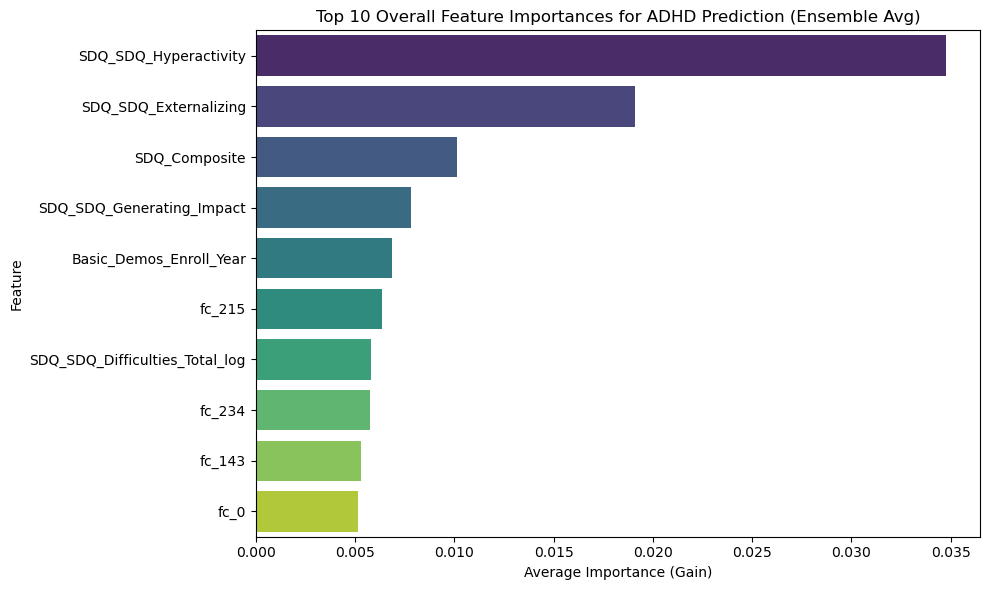

In [22]:
# Plotting Top N Features
N_FEATURES_TO_PLOT = 10
plt.figure(figsize=(10, max(6, N_FEATURES_TO_PLOT / 2.5))) # Dynamic height
sns.barplot(x='Importance', y='Feature', data=importance_df_adhd.head(N_FEATURES_TO_PLOT), palette='viridis')
plt.title(f'Top {N_FEATURES_TO_PLOT} Overall Feature Importances for ADHD Prediction (Ensemble Avg)')
plt.xlabel("Average Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



In [24]:
# --- Threshold Tuning (Keep as is) ---
thresholds_adhd = np.linspace(0.3, 0.7, 81)
thresholds_sex = np.linspace(0.3, 0.7, 81) # Adjusted range slightly from GKF run

best_f1_oof = 0
best_t_adhd_oof = 0.5
best_t_sex_oof = 0.5

for t_adhd in thresholds_adhd:
    for t_sex in thresholds_sex:
        y_pred_oof = np.column_stack([
            (oof_adhd_probs_final > t_adhd).astype(int),
            (oof_sex_probs_final > t_sex).astype(int)
        ])
        f1_oof = weighted_f1_score(y_tr, y_pred_oof)
        if f1_oof > best_f1_oof:
            best_f1_oof = f1_oof
            best_t_adhd_oof = t_adhd
            best_t_sex_oof = t_sex

print(f"\nBest OOF Combined F1 (Ensemble): {best_f1_oof:.4f}") # Should be ~0.7366
print(f"Best ADHD Threshold (OOF Ensemble): {best_t_adhd_oof:.4f}") # Should be ~0.460
print(f"Best Sex_F Threshold (OOF Ensemble): {best_t_sex_oof:.4f}") # Should be ~0.370


Best OOF Combined F1 (Ensemble): 0.7378
Best ADHD Threshold (OOF Ensemble): 0.4350
Best Sex_F Threshold (OOF Ensemble): 0.4000



--- SHAP Analysis for ADHD Prediction in Females ---

Generating SHAP Summary Plot (Bar) for Females (ADHD Prediction)...


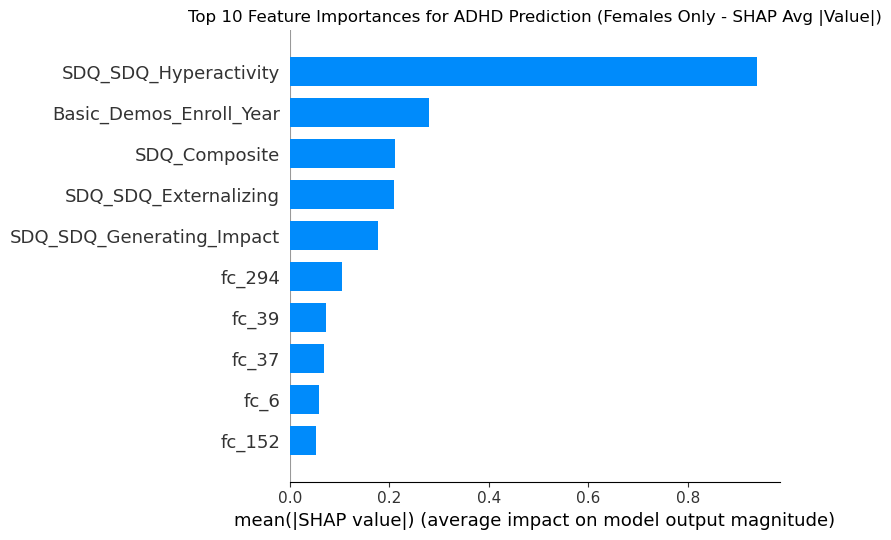


Generating SHAP Summary Plot (Beeswarm) for Females (ADHD Prediction)...


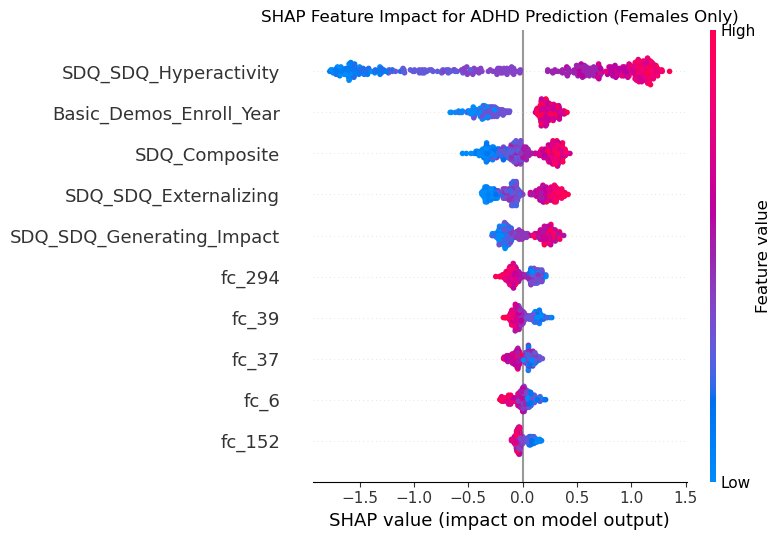

In [26]:
# --- PART 2: SHAP Analysis for ADHD in Females ---
print("\n--- SHAP Analysis for ADHD Prediction in Females ---")
try:
    # Use the first model fitted on full data as representative for SHAP
    explainer_adhd = shap.TreeExplainer(adhd_final_model_for_shap)

    # Calculate SHAP values for the training set
   
    # Use check_additivity=False for potential minor inconsistencies if needed
    shap_values_adhd = explainer_adhd.shap_values(X_tr_proc_df) # , check_additivity=False)
    
    # Handle potential list output for binary classification
    if isinstance(shap_values_adhd, list):
         shap_values_adhd_pos = shap_values_adhd[1] # Index 1 for the positive class (ADHD=1)
    else:
         shap_values_adhd_pos = shap_values_adhd

    # Get indices for female samples
    female_indices = y_tr[y_tr['Sex_F'] == 1].index
    female_locs = [X_tr_proc_df.index.get_loc(idx) for idx in female_indices if idx in X_tr_proc_df.index]

    # Filter SHAP values and data for females
    shap_values_adhd_female = shap_values_adhd_pos[female_locs, :]
    # Need original features (before OHE) for easier interpretation if possible,
    # but using processed features is standard for TreeExplainer with OHE.
    X_tr_proc_female = X_tr_proc_df.iloc[female_locs]

    # SHAP Summary Plot (Bar) for Females
    print("\nGenerating SHAP Summary Plot (Bar) for Females (ADHD Prediction)...")
    plt.figure()
    shap.summary_plot(shap_values_adhd_female, X_tr_proc_female, plot_type="bar", max_display=N_FEATURES_TO_PLOT, show=False)
    plt.title(f"Top {N_FEATURES_TO_PLOT} Feature Importances for ADHD Prediction (Females Only - SHAP Avg |Value|)")
    plt.tight_layout()
    plt.show()

    # SHAP Summary Plot (Beeswarm) for Females
    print("\nGenerating SHAP Summary Plot (Beeswarm) for Females (ADHD Prediction)...")
    plt.figure()
    shap.summary_plot(shap_values_adhd_female, X_tr_proc_female, max_display=N_FEATURES_TO_PLOT, show=False)
    # Title added manually if needed
    plt.title("SHAP Feature Impact for ADHD Prediction (Females Only)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nError during SHAP analysis: {e}")
    print("Ensure SHAP is installed ('pip install shap') and the model is compatible.")


In [28]:
# --- Final Predictions & Submission (Keep as is) ---
print("\nGenerating final test predictions using OOF thresholds on averaged ensemble probabilities...")
y_test_pred = pd.DataFrame({
    "participant_id": X_te_proc_df.index,
    "ADHD_Outcome": (test_adhd_probs_final >= best_t_adhd_oof).astype(int),
    "Sex_F": (test_sex_probs_final >= best_t_sex_oof).astype(int)
})

print("Predicted ADHD_Outcome counts (Ensemble):", np.bincount(y_test_pred['ADHD_Outcome']))
print("Predicted Sex_F counts (Ensemble):", np.bincount(y_test_pred['Sex_F']))


Generating final test predictions using OOF thresholds on averaged ensemble probabilities...
Predicted ADHD_Outcome counts (Ensemble): [ 63 241]
Predicted Sex_F counts (Ensemble): [218  86]


In [ ]:
submission_filename = "submission_ensemble_pca300_N5_BEST.csv" # Filename for best submission
submission_path = f"D:/IT/Kaggle/{submission_filename}" # Update path if needed

try:
    submission = y_test_pred
    submission.to_csv(submission_path, index=False)
    print(f"Submission file created: {submission_path}")
except Exception as e:
    print(f"Error saving submission file: {e}")